In [13]:
import sys 
sys.path.append('/home/weedjo/Udacity/tensorflow/models/research')  
sys.path.append('/home/weedjo/Udacity/tensorflow/models/research/pwd')  
sys.path.append('/home/weedjo/Udacity/tensorflow/models/research/pwd/slim')  

In [14]:
import os
import sys
from glob import glob
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import defaultdict
#from utils import label_map_util
from object_detection.utils import label_map_util
#from utils import visualization_utils as vis_util
from object_detection.utils import visualization_utils as vis_util
import random

%matplotlib inline

In [15]:
def load_graph(graph_file):
    """Loads a frozen inference graph"""
    graph = tf.Graph()
    with graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(graph_file, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    return graph


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

In [16]:
## Test model
# PATH_TO_GRAPH = r'models/rcnn_resnet101/frozen_inference_graph.pb'
# PATH_TO_GRAPH = r'models/rcnn/frozen_inference_graph.pb'
PATH_TO_GRAPH = r'models/ssd_udacity/frozen_inference_graph.pb' ## load SSD trained on udacity's parking lot images
PATH_TO_LABELS = r'data/alex-lechner-udacity-traffic-light-dataset/udacity_label_map.pbtxt'
NUM_CLASSES = 13

In [17]:
detection_graph = load_graph(PATH_TO_GRAPH)

In [18]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)
print(category_index)

{1: {'id': 1, 'name': u'Green'}, 2: {'id': 2, 'name': u'Red'}, 3: {'id': 3, 'name': u'Yellow'}, 4: {'id': 4, 'name': u'off'}}


In [19]:
IMAGE_SIZE = (12, 8)

SCORES
[0.9743927  0.03219047 0.02891559 0.02278391 0.02228953 0.02189181
 0.02152946 0.02144734 0.02112296 0.0209425 ]
CLASSES
[1. 1. 4. 1. 1. 2. 4. 3. 4. 3.]


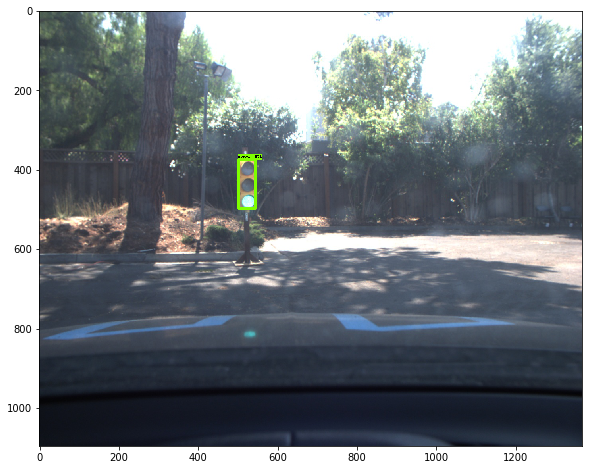

SCORES
[0.8798756  0.03074226 0.03025984 0.02859035 0.02456649 0.02238672
 0.02120242 0.02100848 0.02082744 0.02078863]
CLASSES
[1. 3. 1. 4. 1. 3. 1. 1. 4. 1.]


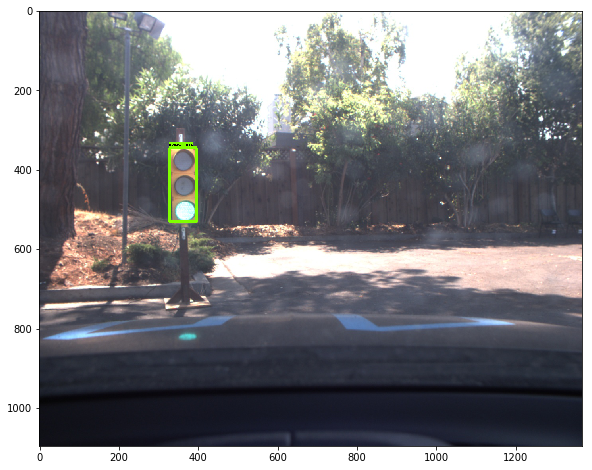

SCORES
[0.46101952 0.20942506 0.0333778  0.0315266  0.02698805 0.0252857
 0.02520847 0.02443906 0.02350098 0.02344973]
CLASSES
[2. 2. 4. 3. 3. 3. 4. 4. 3. 1.]


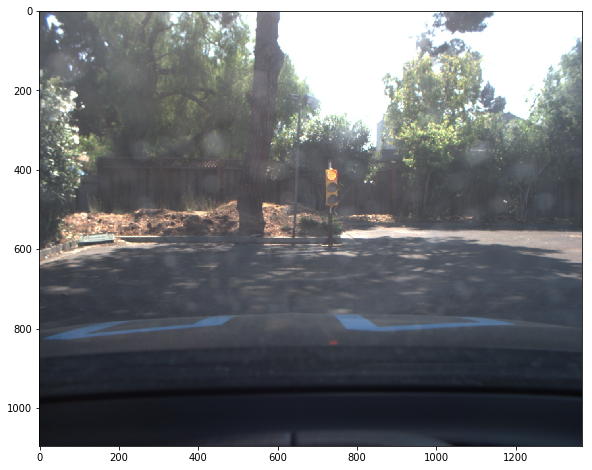

SCORES
[0.9771299  0.02797686 0.02531668 0.02350093 0.02283205 0.02265041
 0.02258796 0.02236786 0.02231915 0.02186374]
CLASSES
[1. 4. 3. 4. 4. 4. 2. 3. 4. 3.]


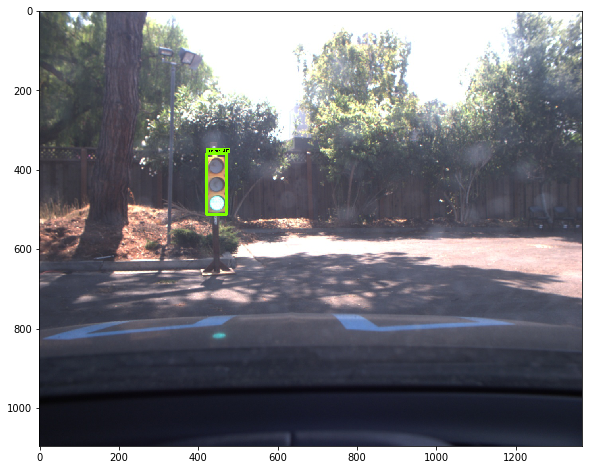

SCORES
[0.9739794  0.03049932 0.02462221 0.02417117 0.02409211 0.02403564
 0.02383803 0.0230166  0.02268839 0.02233959]
CLASSES
[1. 4. 3. 4. 1. 1. 4. 1. 1. 1.]


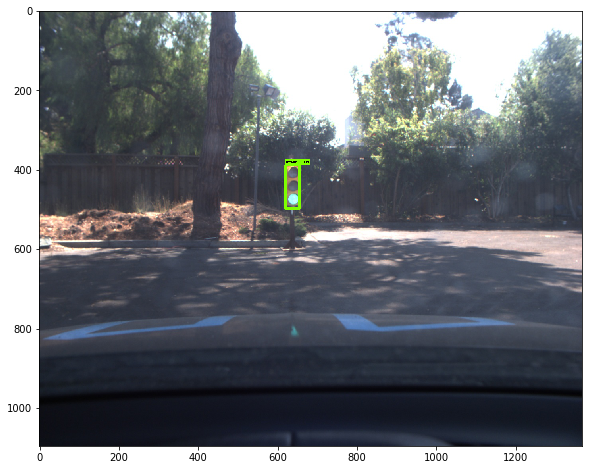

SCORES
[0.46101952 0.20942506 0.0333778  0.0315266  0.02698805 0.0252857
 0.02520847 0.02443906 0.02350098 0.02344973]
CLASSES
[2. 2. 4. 3. 3. 3. 4. 4. 3. 1.]


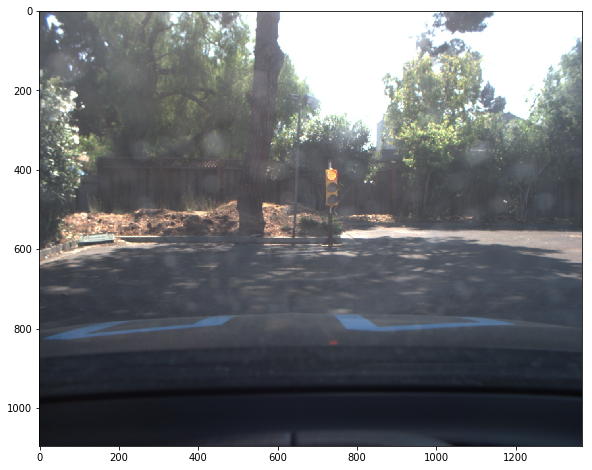

SCORES
[0.14596044 0.02913498 0.02754906 0.02633503 0.02546998 0.02455631
 0.02407894 0.02348617 0.02333329 0.02239821]
CLASSES
[1. 4. 3. 1. 4. 1. 4. 1. 1. 1.]


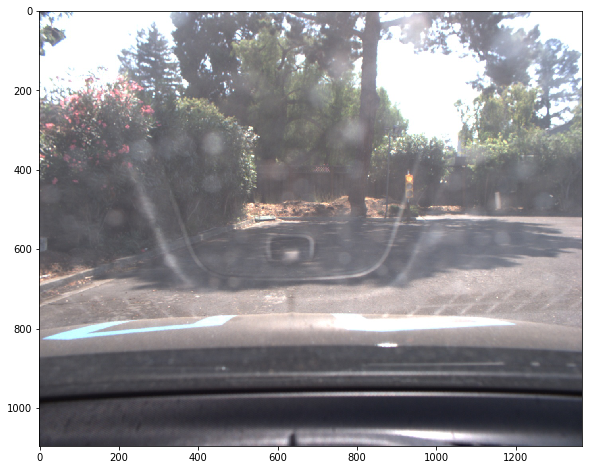

SCORES
[0.9743927  0.03219047 0.02891559 0.02278391 0.02228953 0.02189181
 0.02152946 0.02144734 0.02112296 0.0209425 ]
CLASSES
[1. 1. 4. 1. 1. 2. 4. 3. 4. 3.]


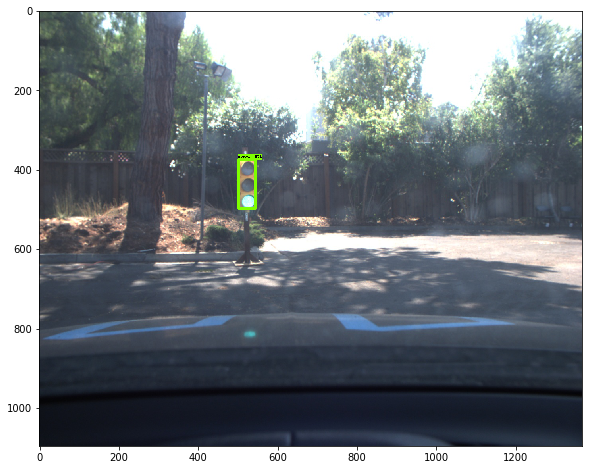

SCORES
[0.994072   0.03956893 0.03462442 0.03098899 0.02981027 0.02873856
 0.02829726 0.02696683 0.02695961 0.02693332]
CLASSES
[1. 1. 3. 3. 3. 1. 4. 1. 3. 3.]


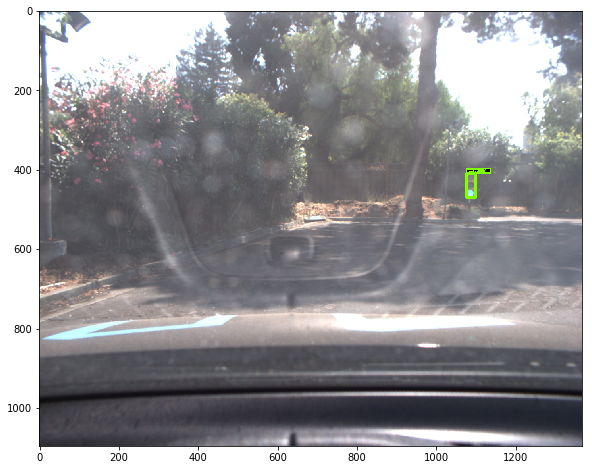

SCORES
[0.93313754 0.03364089 0.03056359 0.02440432 0.02361615 0.02222816
 0.02168833 0.02129546 0.02126334 0.02123721]
CLASSES
[1. 4. 4. 3. 2. 2. 4. 2. 3. 1.]


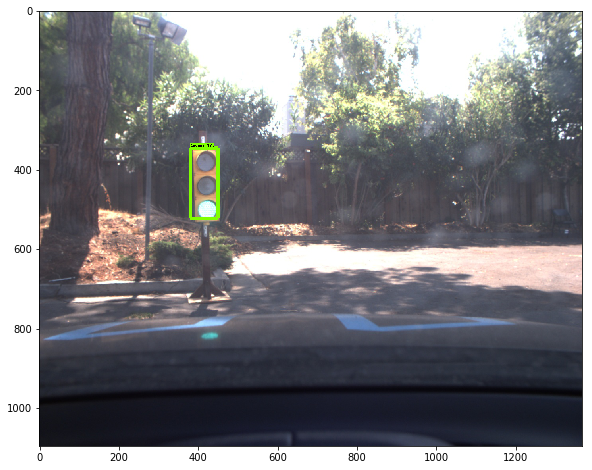

SCORES
[0.9816742  0.02722038 0.0250157  0.02368549 0.02361336 0.02341832
 0.0231945  0.02317985 0.02278677 0.02180279]
CLASSES
[1. 1. 3. 1. 1. 1. 3. 1. 3. 2.]


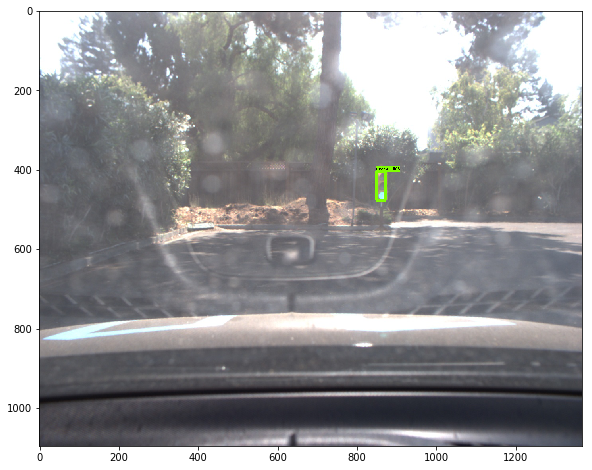

In [20]:
PATH_TO_IMGS = r'data/alex-lechner-udacity-traffic-light-dataset/udacity_testarea_rgb'
TEST_IMGS = glob(os.path.join(PATH_TO_IMGS, r'*.jpg'))
random.shuffle(TEST_IMGS)

with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        detect_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        detect_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detect_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        
        for idx, img_path in enumerate(TEST_IMGS):
            random.shuffle(TEST_IMGS)
            image = Image.open(img_path)
            image_np = load_image_into_numpy_array(image)
            image_expanded = np.expand_dims(image_np, axis=0)
            
            (boxes, scores, classes, num) = sess.run(
                [detect_boxes, detect_scores, detect_classes, num_detections],
                feed_dict={image_tensor: image_expanded})
            
            print('SCORES')
            print(scores[0])
            print('CLASSES')
            print(classes[0])
            
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np, 
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                line_thickness=8)
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_np)
            plt.show()
            
            if idx == 10:
                break

In [21]:
PATH_TO_GRAPH = r'models/ssd_sim/frozen_inference_graph.pb' ## load SSD trained on udacity's simulator images
detection_graph = load_graph(PATH_TO_GRAPH)

NotFoundError: models/ssd_sim/frozen_inference_graph.pb; No such file or directory

In [ ]:
PATH_TO_IMGS = r'data/simulator_dataset_rgb'
subfolder = ['Green', 'Red', 'Yellow', 'Unknown']
TEST_IMGS = []
for i in subfolder:
    TEST_IMGS += glob(os.path.join(os.path.join(PATH_TO_IMGS, i), r'*.jpg'))
random.shuffle(TEST_IMGS)

with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        detect_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        detect_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detect_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        
        for idx, img_path in enumerate(TEST_IMGS):
            image = Image.open(img_path)
            image_np = load_image_into_numpy_array(image)
            image_expanded = np.expand_dims(image_np, axis=0)
            
            (boxes, scores, classes, num) = sess.run(
                [detect_boxes, detect_scores, detect_classes, num_detections],
                feed_dict={image_tensor: image_expanded})
            
            print('SCORES')
            print(scores[0])
            print('CLASSES')
            print(classes[0])
            
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np, 
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                line_thickness=8)
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_np)
            plt.show()
            
            if idx == 10:
                break